In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import math
import random
from tqdm import tqdm_notebook
import matplotlib
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)

from datetime import datetime
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
path='../input/ashrae-energy-prediction/'
path_new = '../input/lag-transform/'
from sklearn.metrics import roc_auc_score,mean_squared_error
from sklearn.model_selection import StratifiedKFold,TimeSeriesSplit, train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import sin,log,pow
import lightgbm as lgb
import datetime
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import multiprocessing as mp
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial
pd.options.mode.chained_assignment = None
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
def ls():
     print([v for v in globals().keys() if not v.startswith('_')])
        
from itertools import groupby
from operator import itemgetter

def get_info_consecutive(data,max_len=24):
    return([x for x in [(next(g), sum(1 for i in g)+1) for k, g in groupby(enumerate(data), key=itemgetter(1))] if x[1]>max_len])

def get_position_consecutive(infol):
    pos = []
    for x in infol:
        pos += np.arange(start=x[0][0]+1,stop=x[0][0]+x[1]).tolist()
    return(pos)
def free_space(del_list):
    for name in del_list:
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()

scatter = True

../input/ashrae-energy-prediction/building_metadata.csv
../input/ashrae-energy-prediction/weather_train.csv
../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/test.csv
../input/ashrae-energy-prediction/train.csv


In [2]:
def importer(align=False,drop_consecutive=False):
    train = pd.read_csv(f'{path}train.csv')
    train['timestamp'] = pd.to_datetime(train['timestamp'],format='%Y-%m-%d %H:%M:%S')
    train['meter_reading'] = np.log1p(train['meter_reading'])
    weather_train = pd.read_csv(f'{path_new}new_weather_train.csv')
    weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'],format='%Y-%m-%d %H:%M:%S')

    building_metadata = pd.read_csv(f'{path}building_metadata.csv')
    building_metadata = building_metadata[['site_id','building_id','primary_use']]

#     weather_train['country'] = weather_train['site_id'].map(country)
    timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
    weather_train['time_diff'] = weather_train['site_id'].map(timediff)
    weather_train['time_diff'] = pd.to_timedelta(weather_train['time_diff'],'h')
    if align:
        weather_train['timestamp'] = weather_train['timestamp'] - weather_train['time_diff']
        
    # target_train_df['hour'] = target_train_df['hour'] + target_train_df['time_diff']
    # target_train_df.loc[target_train_df['hour']>23, 'hour'] = target_train_df[target_train_df['hour']>23]['hour'] - 24

    train = train.merge(building_metadata, left_on = "building_id", right_on = "building_id", how = "left")
    country = {0:'UnitedStates',1:'England',2:'UnitedStates',3:'UnitedStates',4:'UnitedStates',
           5:'England',6:'UnitedStates',7:'Canada',8:'UnitedStates',9:'UnitedStates',10:'UnitedStates',
           11:'Canada',12:'Ireland',13:'UnitedStates',14:'UnitedStates',15:'UnitedStates'}
    city = {0:'Jacksonville',1:'London',2:'Phoenix',3:'Philadelphia',4:'San Francisco',
           5:'Loughborough',6:'Philadelphia',7:'Montreal',8:'Jacksonville',9:'San Antonio',10:'Las Vegas',
           11:'Montreal',12:'Dublin',13:'Minneapolis',14:'Philadelphia',15:'Pittsburgh'} 
    train['country'] = train['site_id'].map(country)
    train['city'] = train['site_id'].map(city)

    train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"], how = "left")

    if drop_consecutive:
        train_df = pd.DataFrame({'building_id':train.building_id,'meter':train.meter,'meter_reading':train.meter_reading})

        train_df['dummy'] = np.arange(train_df.shape[0])
        position = []
        for building_id in tqdm_notebook(range(1449)):
            train_gb = train_df[train_df['building_id'] == building_id].groupby("meter")

            for meter, tmp_df in train_gb:
                data = tmp_df['meter_reading'].values

                infol = get_info_consecutive(data=data,max_len=24)

                position += tmp_df.iloc[get_position_consecutive(infol),:]['dummy'].tolist()
        position = np.sort(position).tolist()
        train.drop(position,axis=0,inplace=True)
    return(train)

In [3]:
train_align = importer(align = True,drop_consecutive=False)

In [4]:
graph_df = train_align.copy()
graph_df['meter_reading']=np.expm1(graph_df['meter_reading'])
graph_df['data'] = graph_df['timestamp']
graph_df['data'] = graph_df['data'].dt.date
graph_df['year'] = graph_df['timestamp']
graph_df['year'] = graph_df['year'].dt.year
free_space(['train_align'])

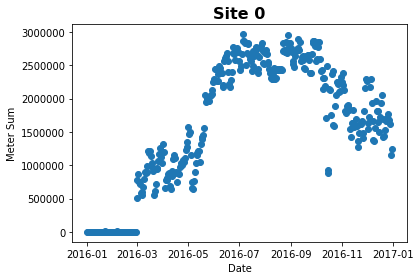

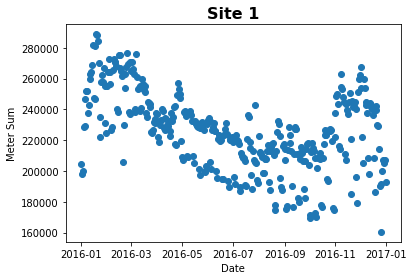

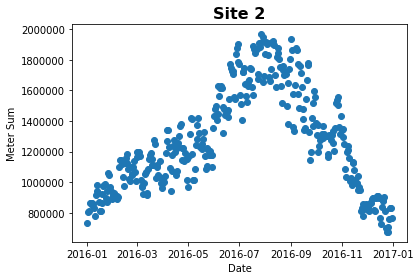

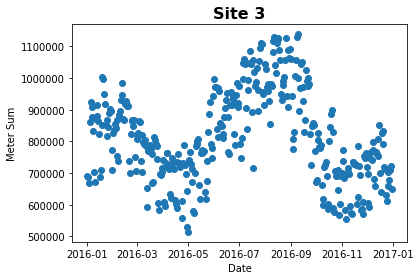

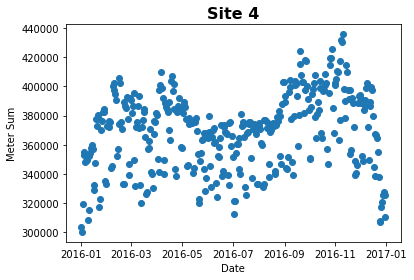

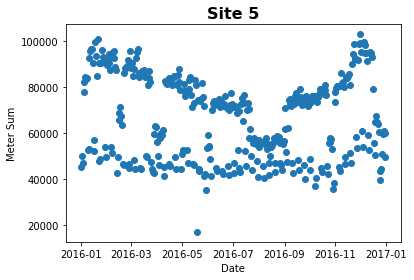

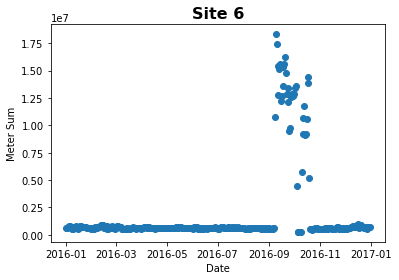

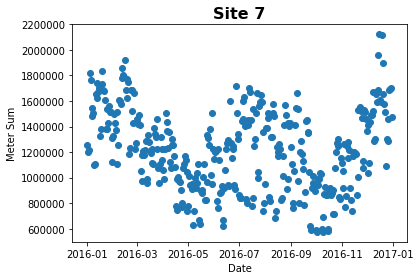

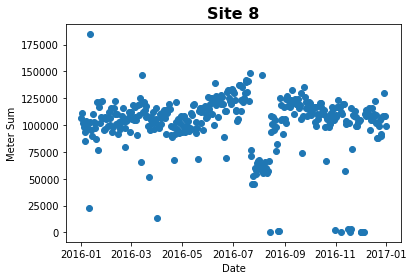

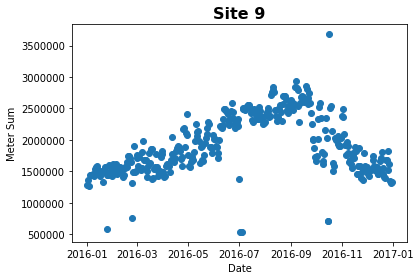

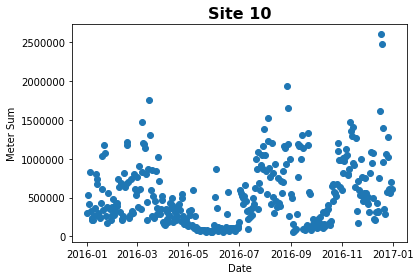

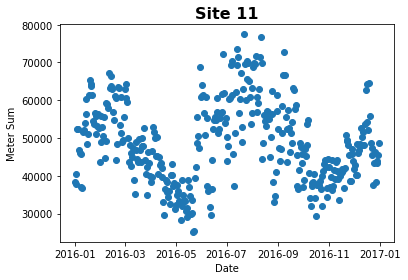

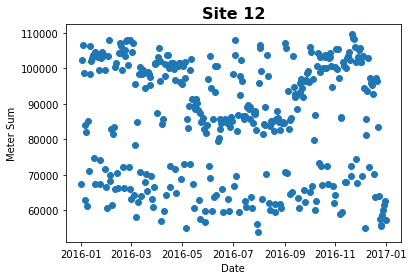

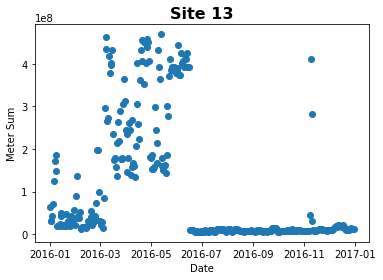

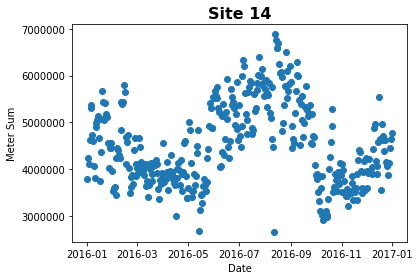

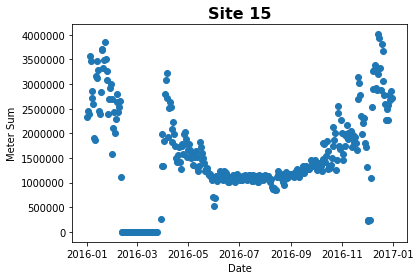

In [5]:
graph_info = graph_df.groupby(['site_id','data'])['meter_reading'].sum().reset_index()
for site in np.sort(graph_info['site_id'].unique()):
    mask = (graph_info['site_id']==site)
    if scatter:
        plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
    else:
        sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
    plt.title("Site {}".format(site),fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Meter Sum")
    plt.show()

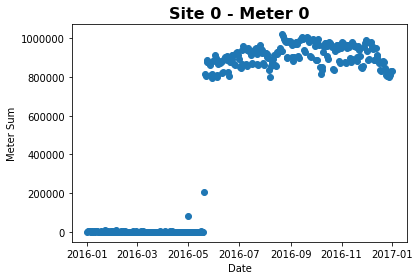

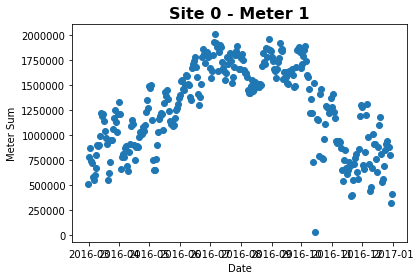

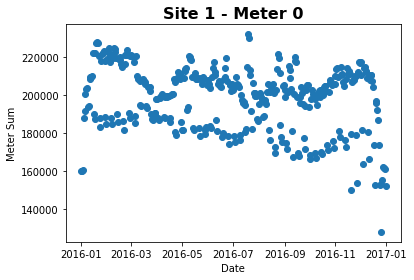

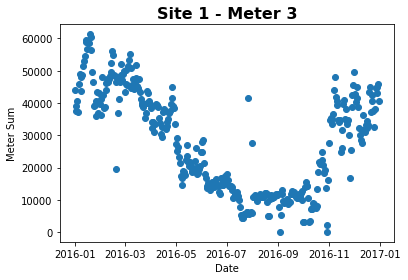

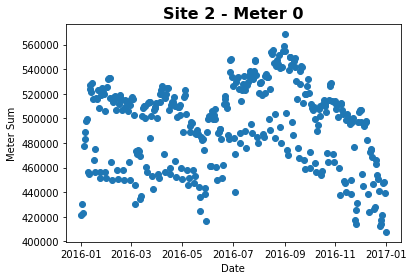

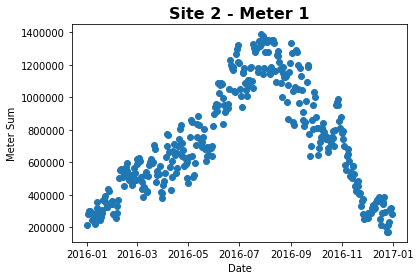

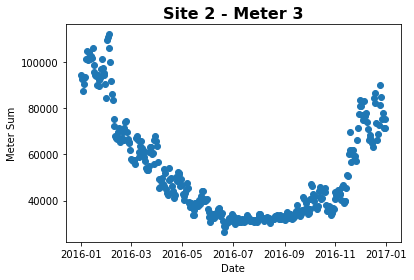

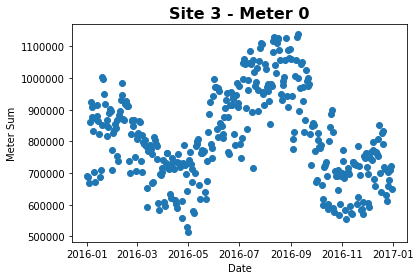

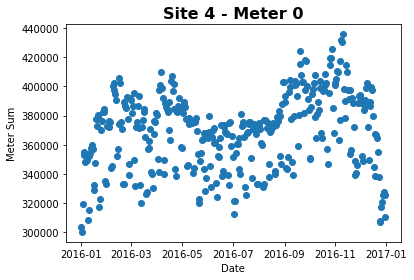

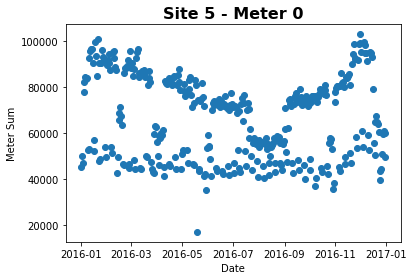

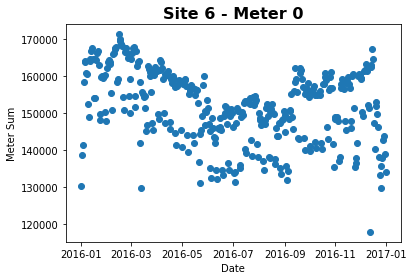

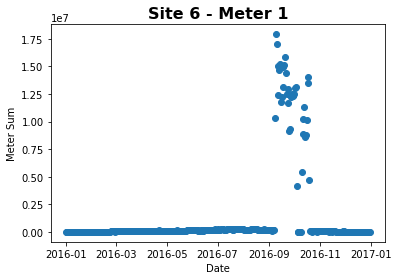

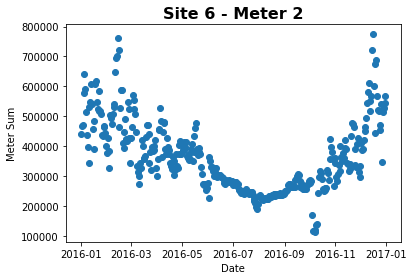

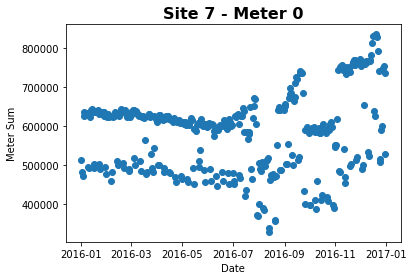

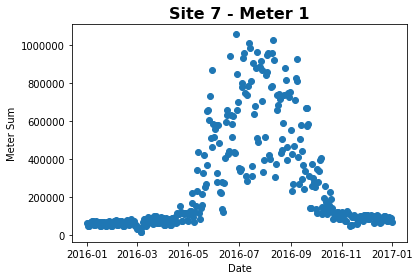

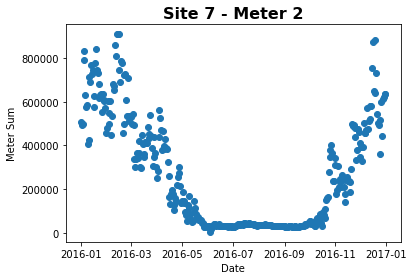

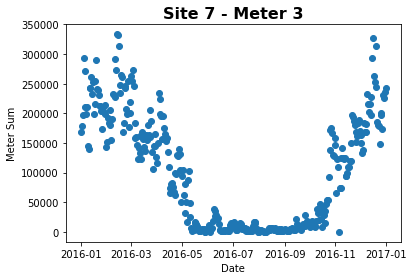

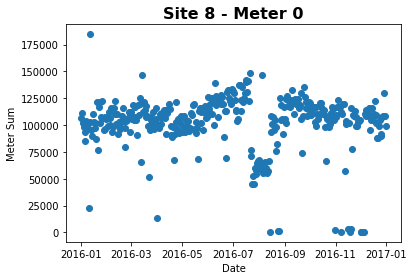

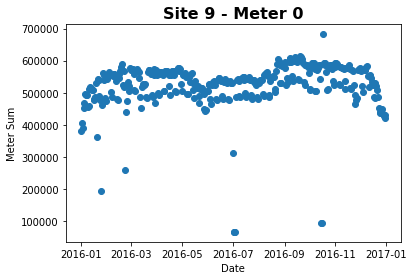

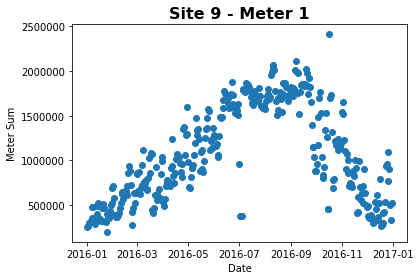

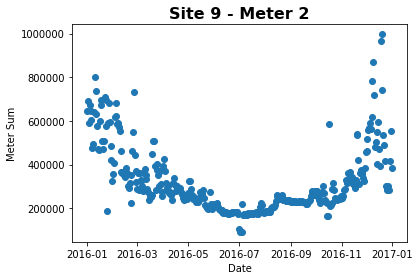

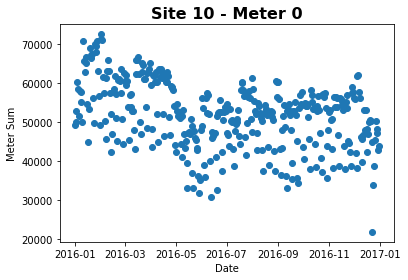

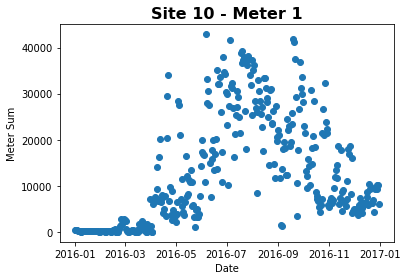

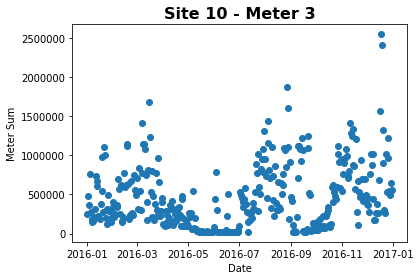

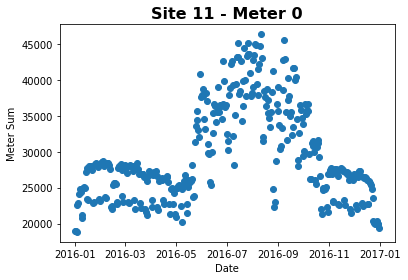

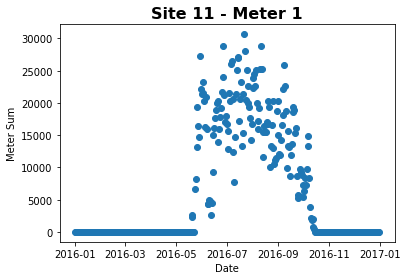

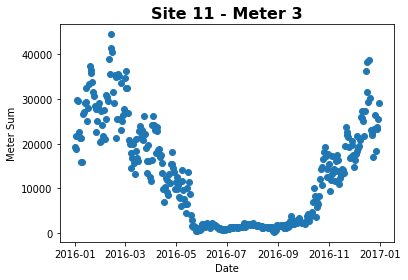

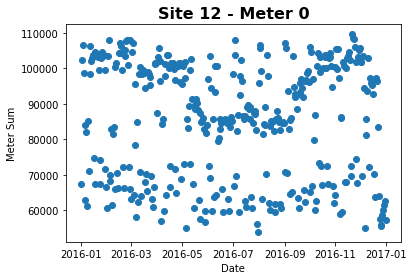

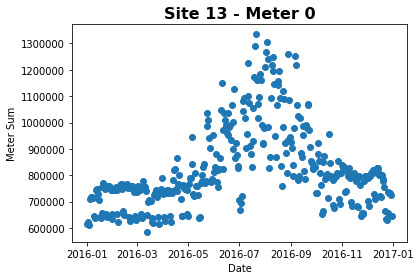

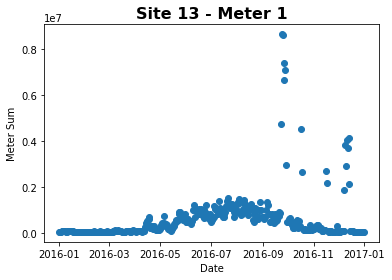

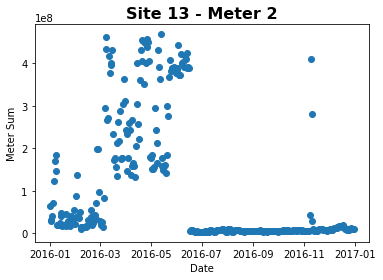

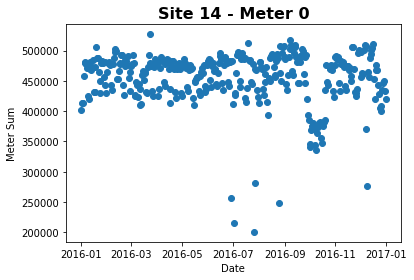

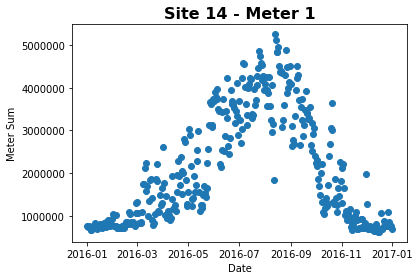

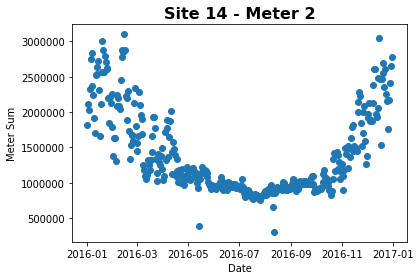

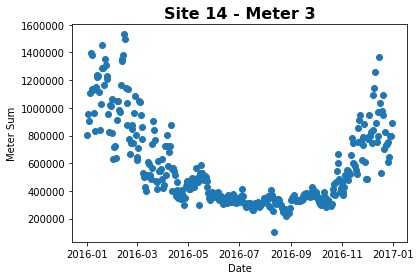

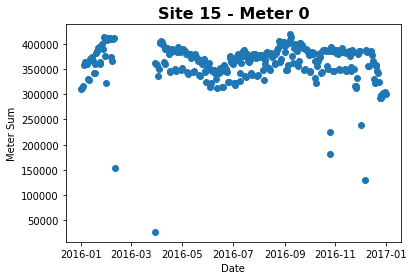

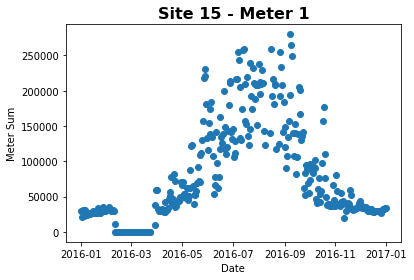

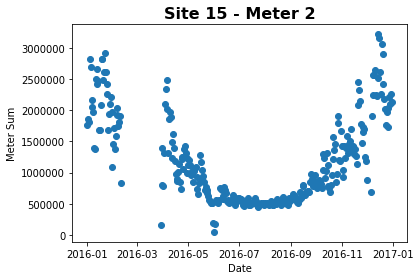

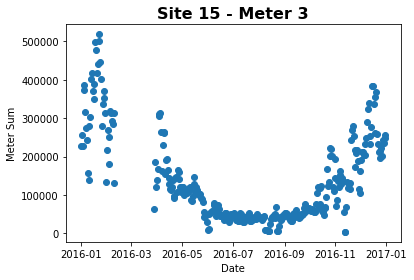

In [6]:
graph_info = graph_df.groupby(['site_id','meter','data'])['meter_reading'].sum().reset_index()
for site in np.sort(graph_info['site_id'].unique()):
    for meter in graph_info.loc[graph_info['site_id']==site,'meter'].unique():
        mask = (graph_info['site_id']==site) & (graph_info['meter']==meter)
        if scatter:
            plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
        else:
            sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
        plt.title("Site {} - Meter {}".format(site,meter),fontsize=16, fontweight='bold')
        plt.xlabel("Date")
        plt.ylabel("Meter Sum")
        plt.show()

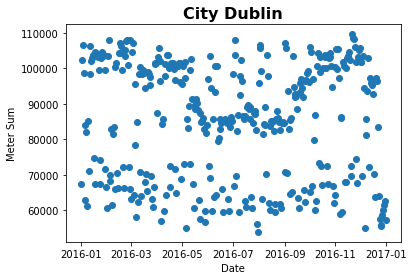

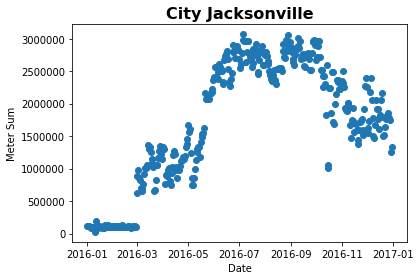

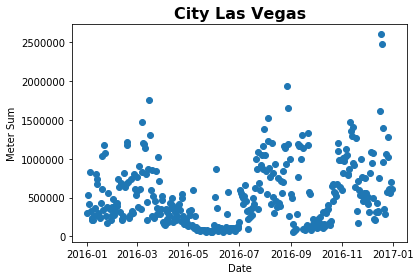

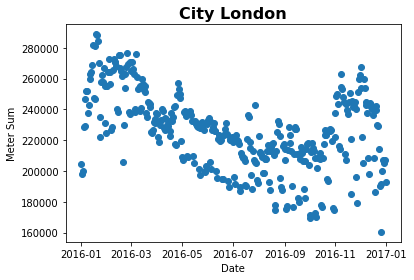

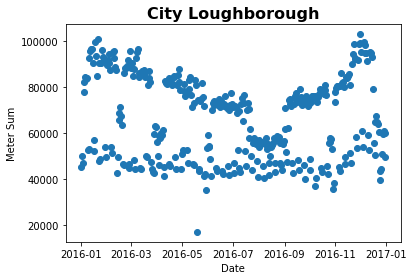

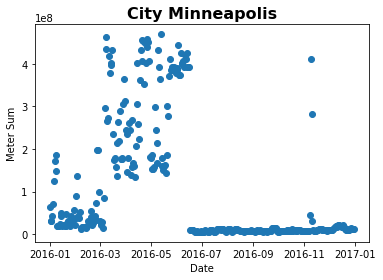

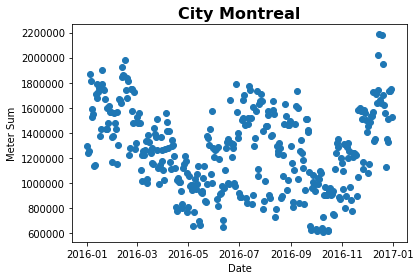

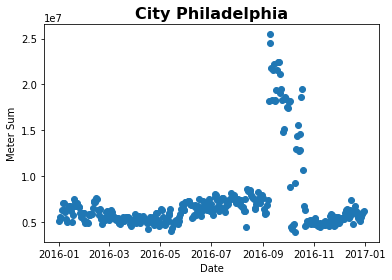

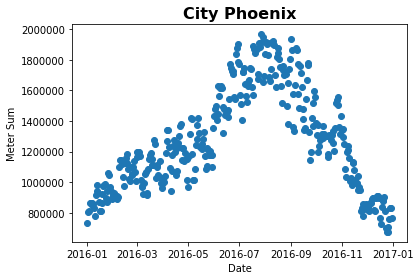

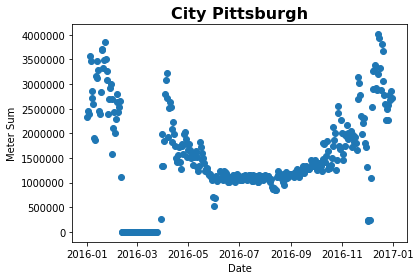

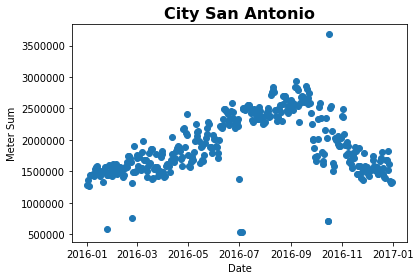

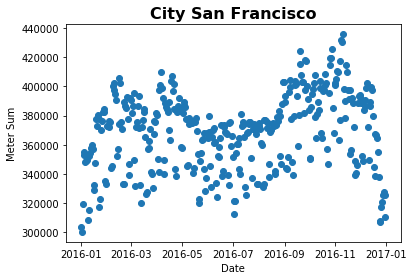

In [7]:
graph_info = graph_df.groupby(['city','data'])['meter_reading'].sum().reset_index()
for city in graph_info['city'].unique():
    mask = (graph_info['city']==city)
    if scatter:
        plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
    else:
        sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
    plt.title("City {}".format(city),fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Meter Sum")
    plt.show()

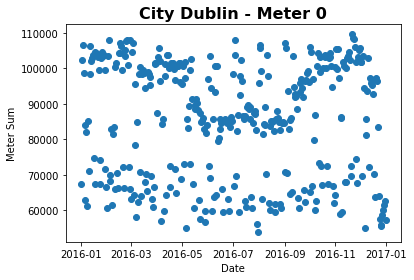

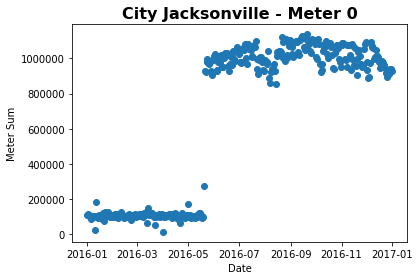

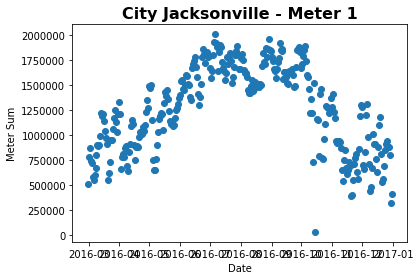

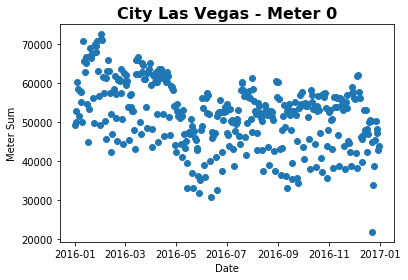

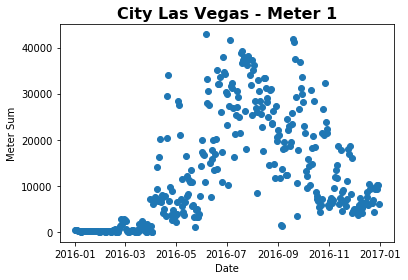

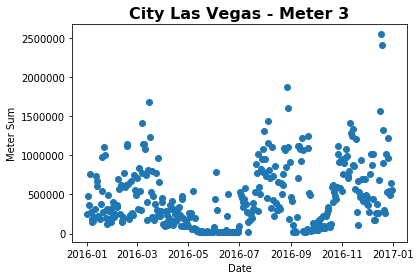

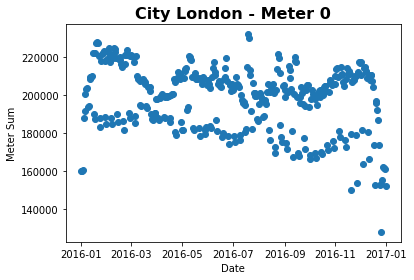

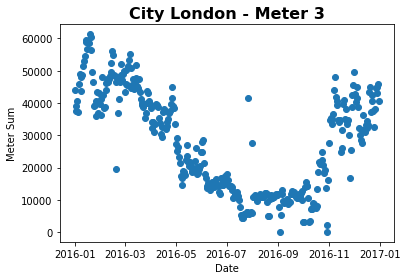

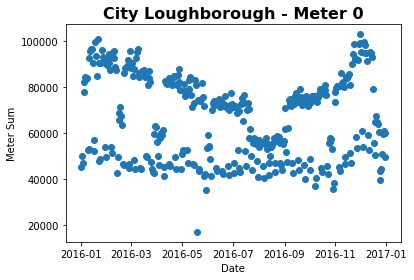

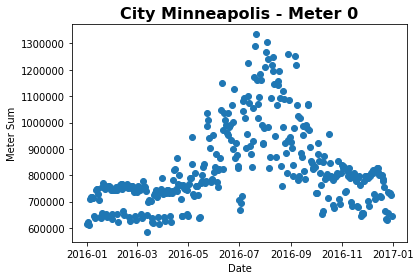

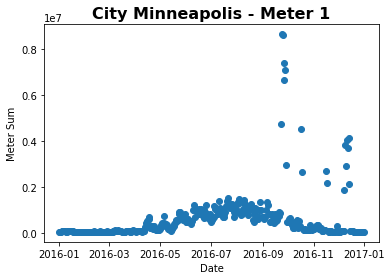

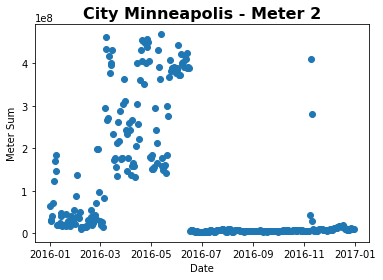

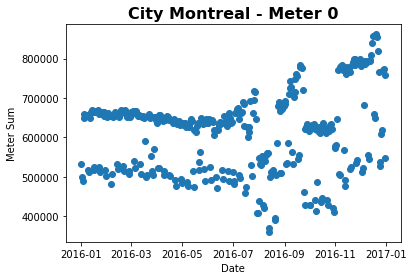

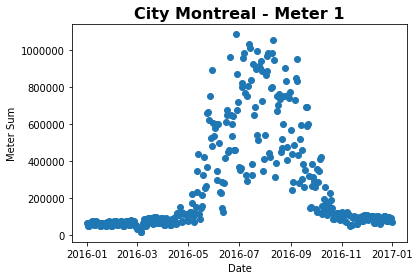

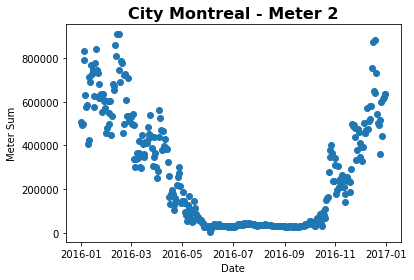

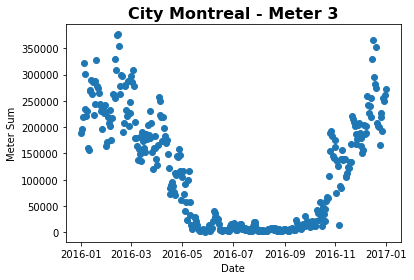

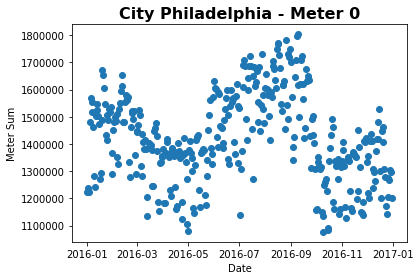

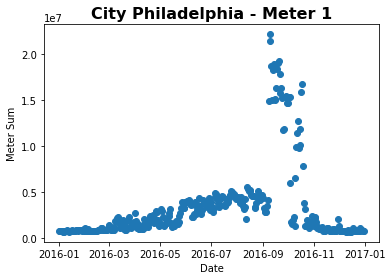

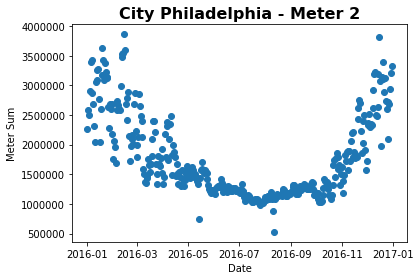

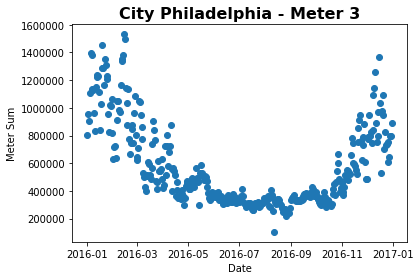

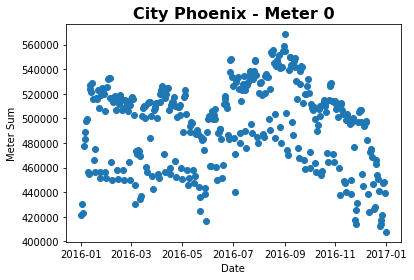

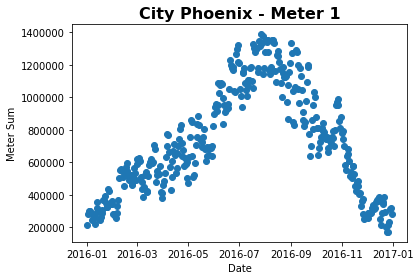

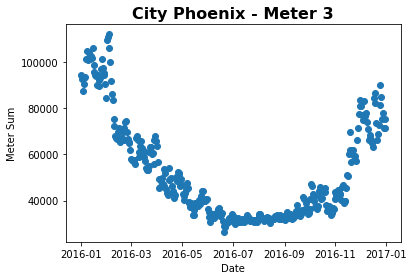

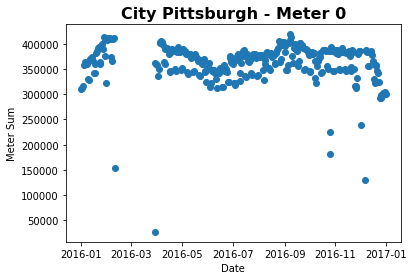

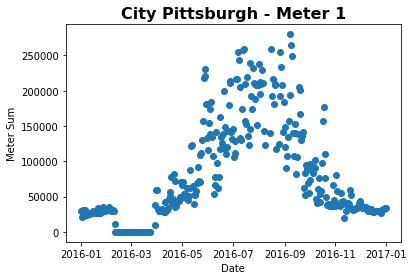

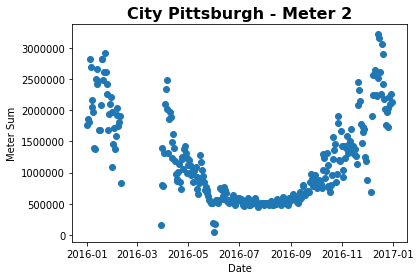

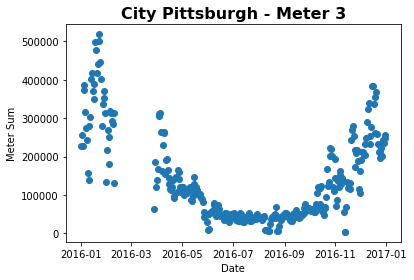

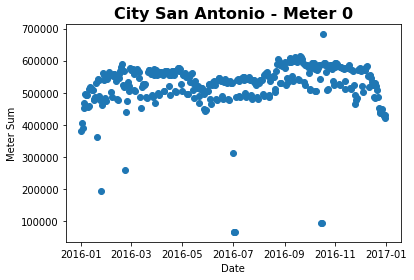

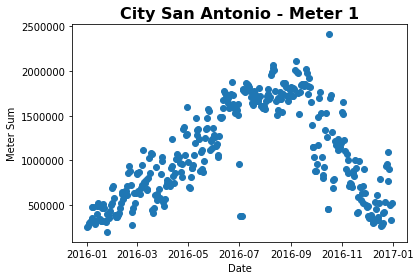

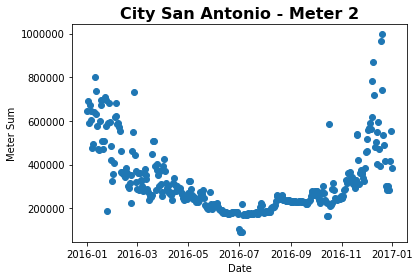

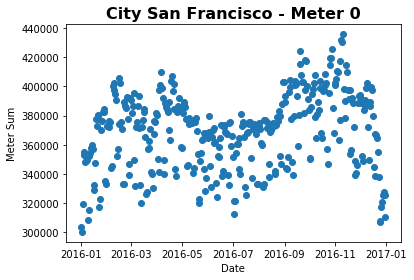

In [8]:
graph_info = graph_df.groupby(['city','meter','data'])['meter_reading'].sum().reset_index()
for city in np.sort(graph_info['city'].unique()):
    for meter in graph_info.loc[graph_info['city']==city,'meter'].unique():
        mask = (graph_info['city']==city) & (graph_info['meter']==meter)
        if scatter:
            plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
        else:
            sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
        plt.title("City {} - Meter {}".format(city,meter),fontsize=16, fontweight='bold')
        plt.xlabel("Date")
        plt.ylabel("Meter Sum")
        plt.show()

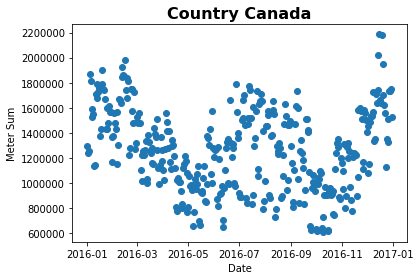

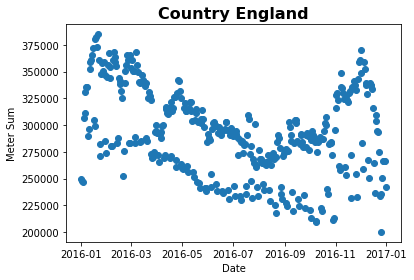

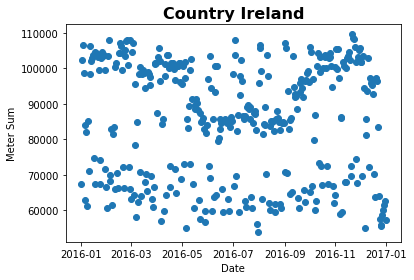

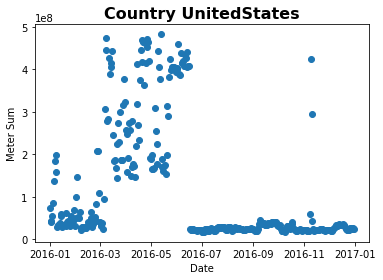

In [9]:
graph_info = graph_df.groupby(['country','data'])['meter_reading'].sum().reset_index()
for country in graph_info['country'].unique():
    mask = (graph_info['country']==country)
    if scatter:
        plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
    else:
        sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
    plt.title("Country {}".format(country),fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Meter Sum")
    plt.show()

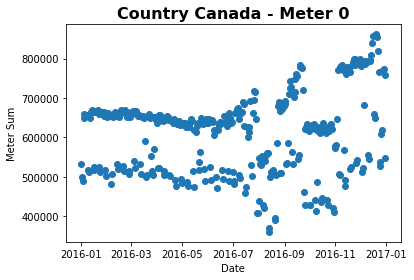

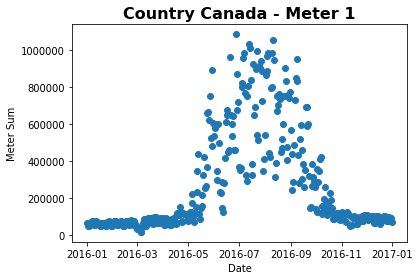

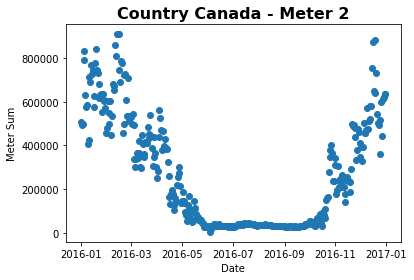

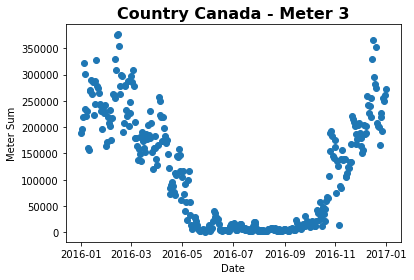

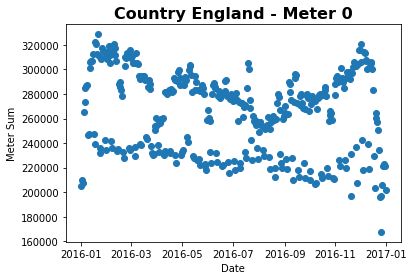

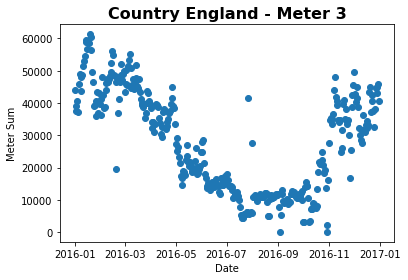

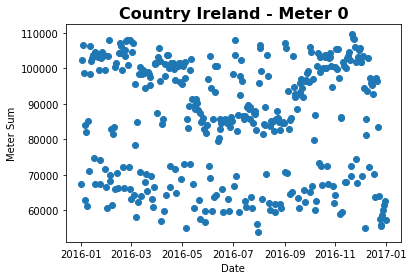

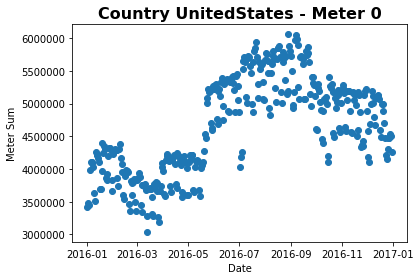

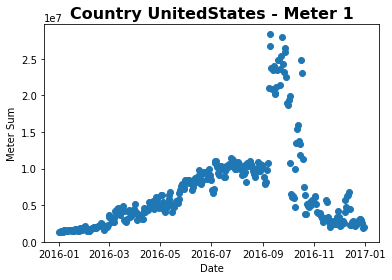

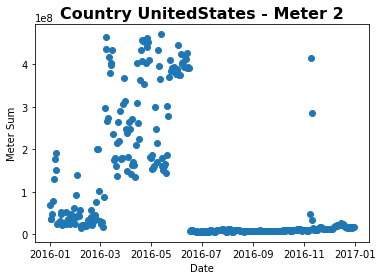

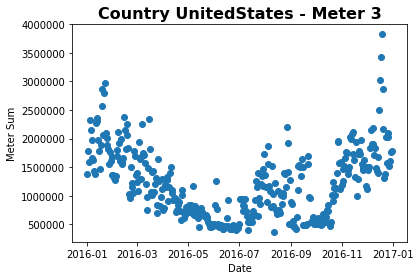

In [10]:
graph_info = graph_df.groupby(['country','meter','data'])['meter_reading'].sum().reset_index()
for country in np.sort(graph_info['country'].unique()):
    for meter in graph_info.loc[graph_info['country']==country,'meter'].unique():
        mask = (graph_info['country']==country) & (graph_info['meter']==meter)
        if scatter:
            plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
        else:
            sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
        plt.title("Country {} - Meter {}".format(country,meter),fontsize=16, fontweight='bold')
        plt.xlabel("Date")
        plt.ylabel("Meter Sum")
        plt.show()

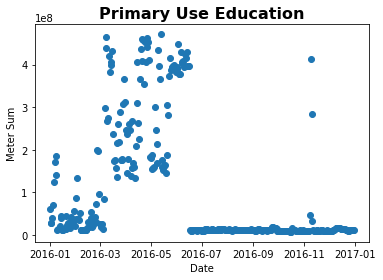

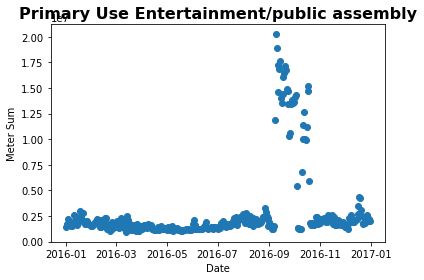

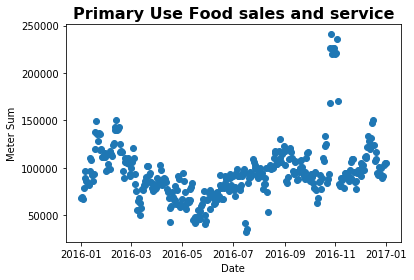

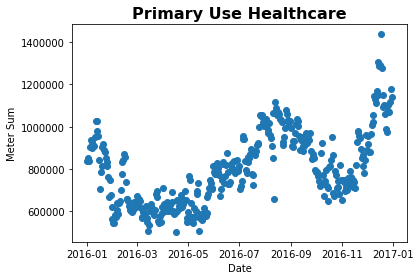

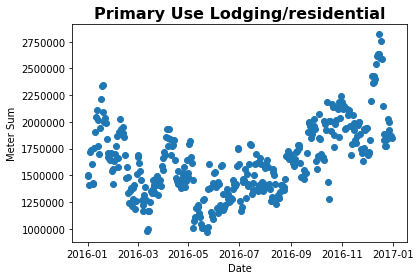

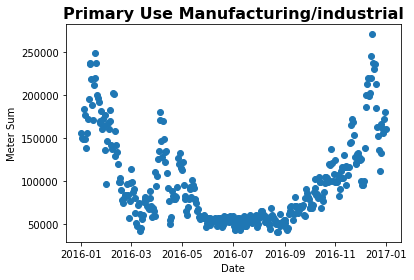

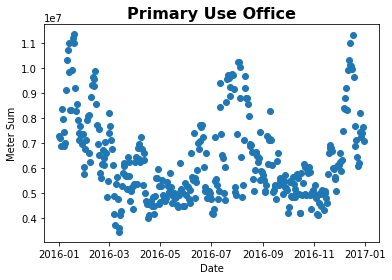

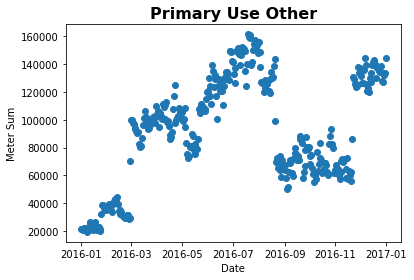

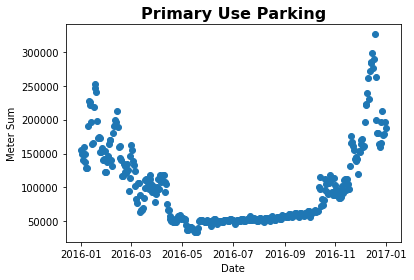

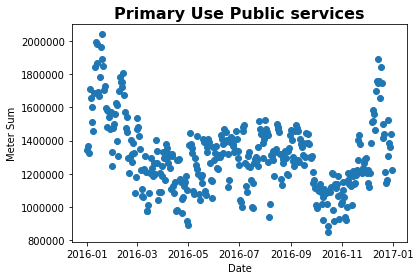

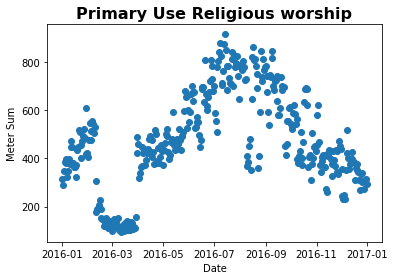

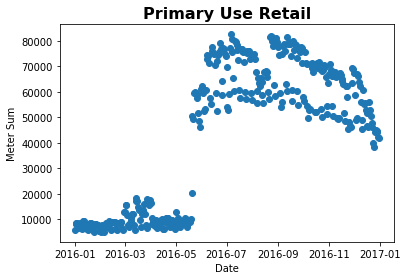

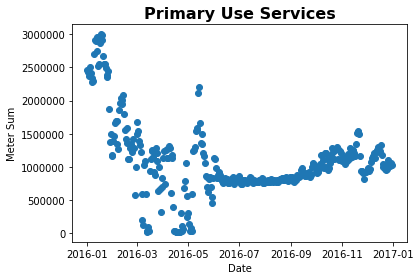

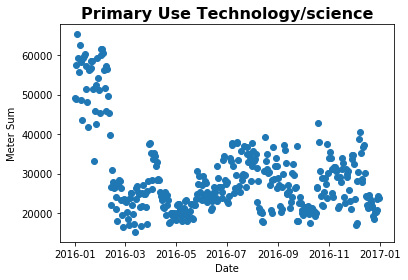

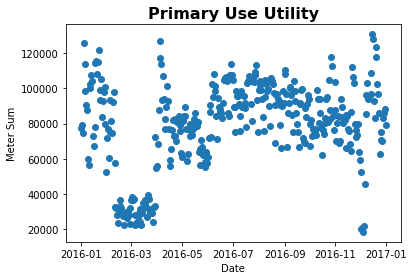

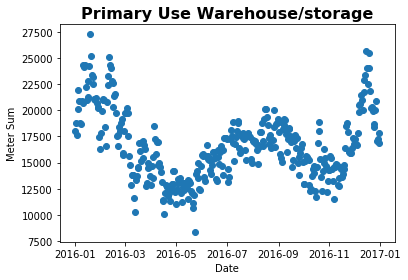

In [11]:
graph_info = graph_df.groupby(['primary_use','data'])['meter_reading'].sum().reset_index()
for primary_use in graph_info['primary_use'].unique():
    mask = (graph_info['primary_use']==primary_use)
    if scatter:
        plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
    else:
        sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
    plt.title("Primary Use {}".format(primary_use),fontsize=16, fontweight='bold')
    plt.xlabel("Date")
    plt.ylabel("Meter Sum")
    plt.show()

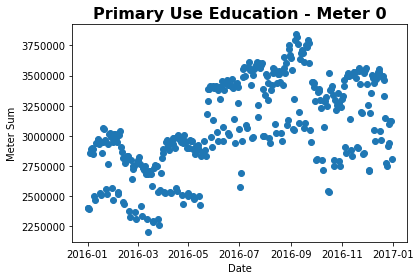

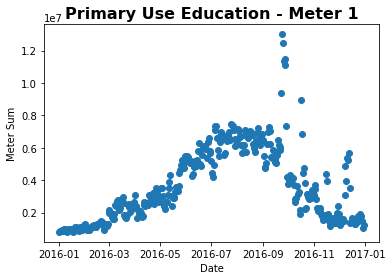

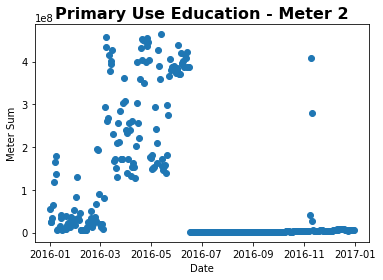

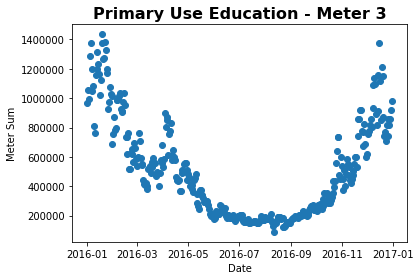

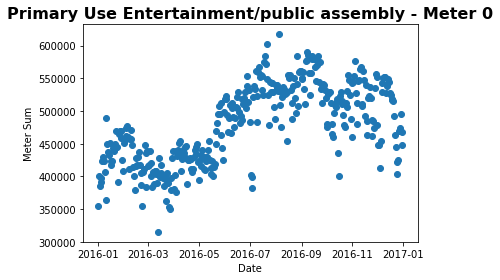

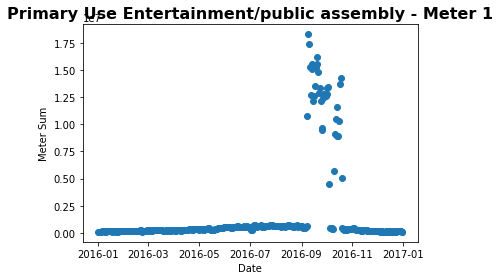

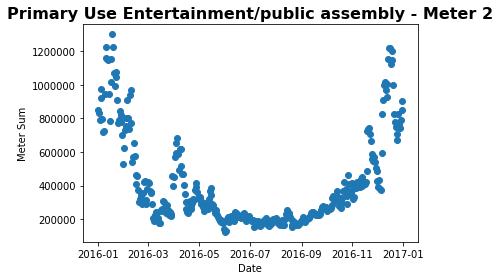

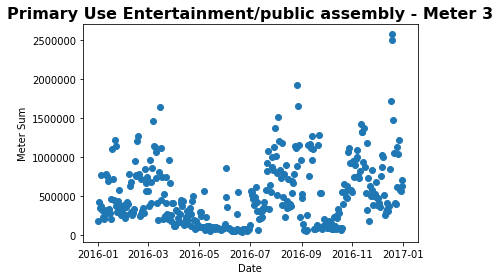

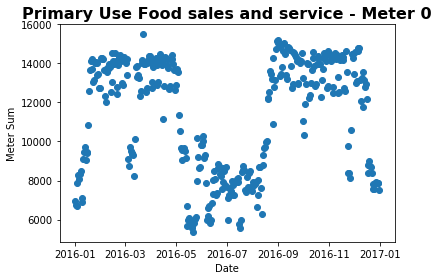

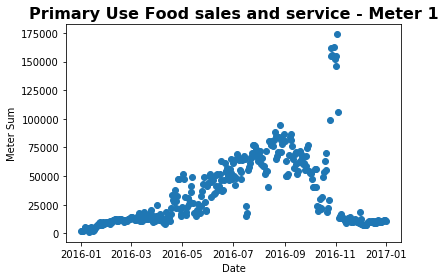

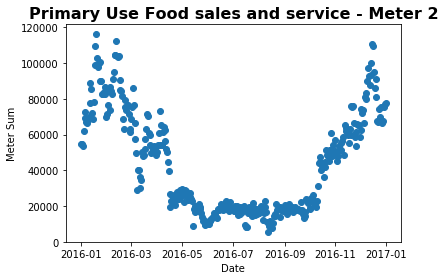

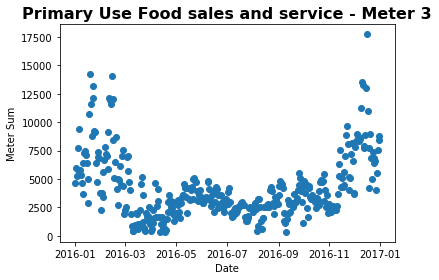

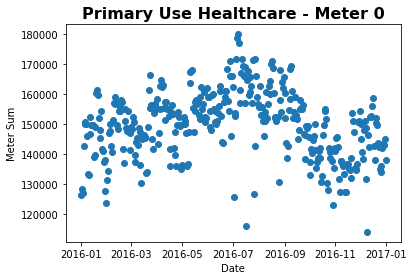

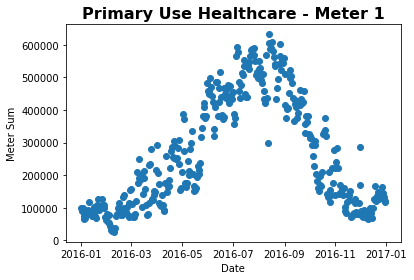

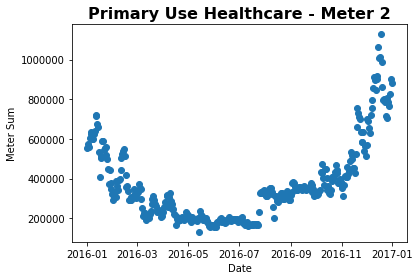

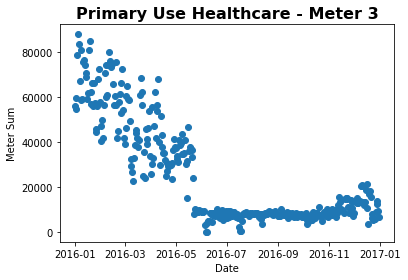

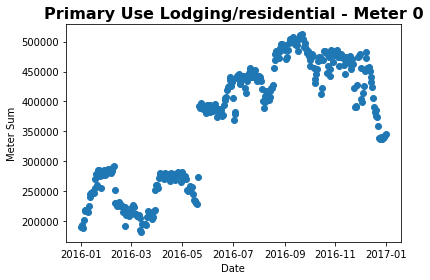

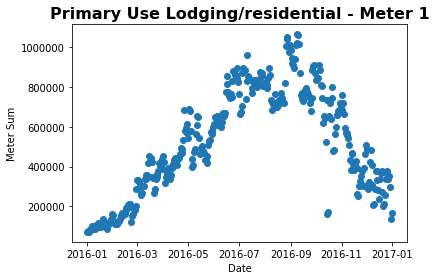

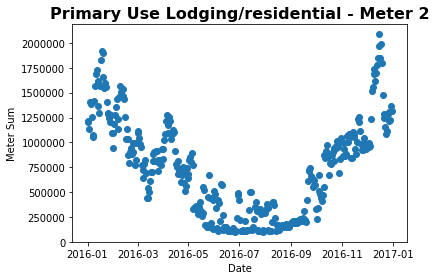

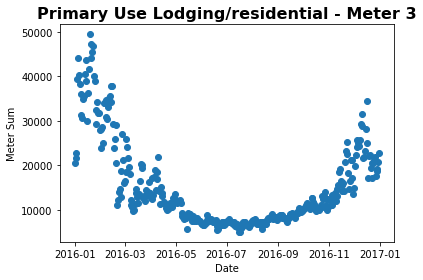

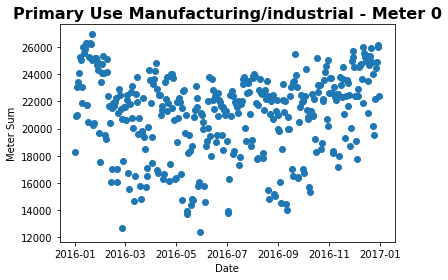

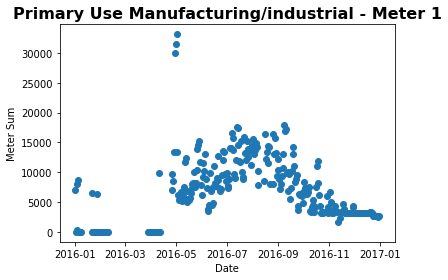

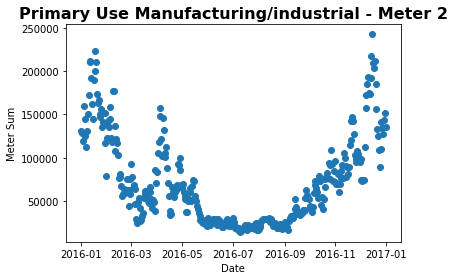

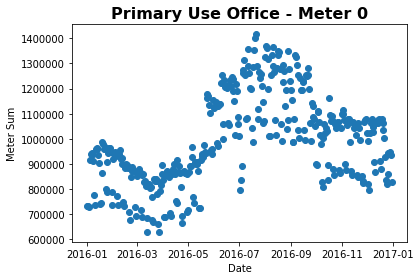

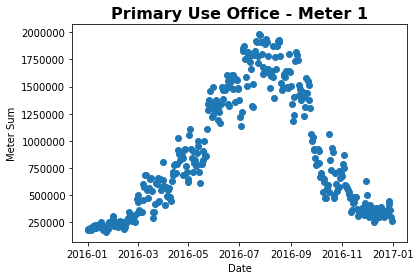

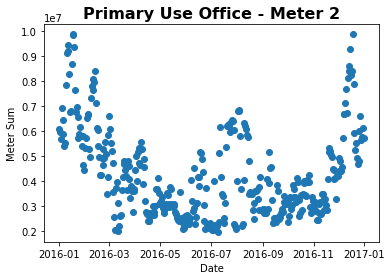

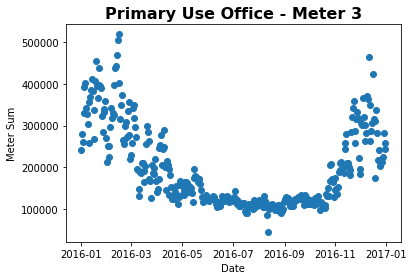

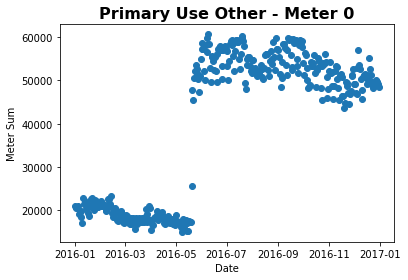

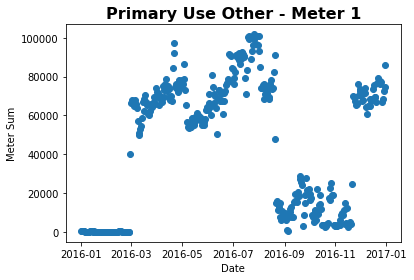

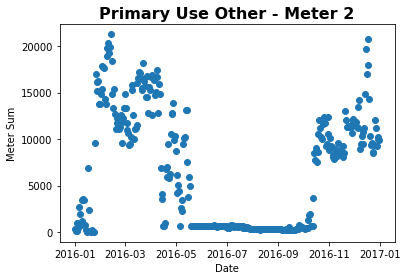

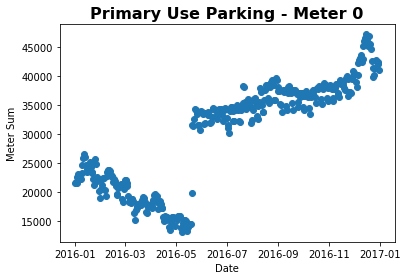

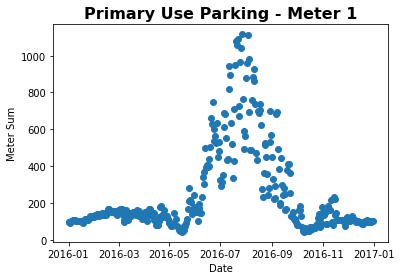

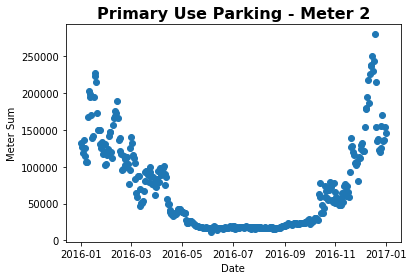

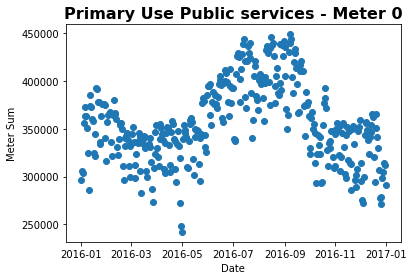

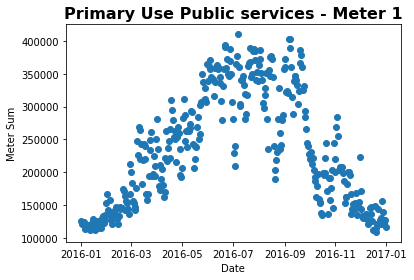

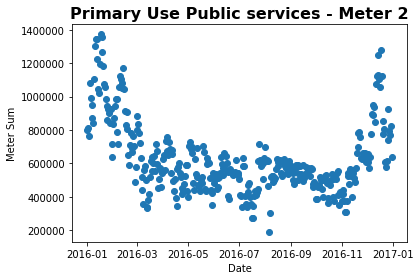

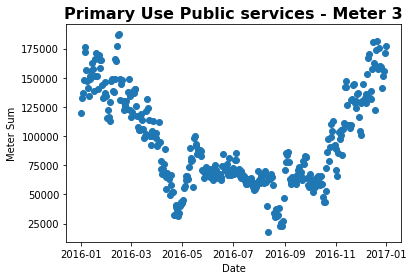

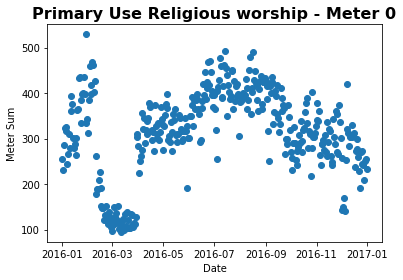

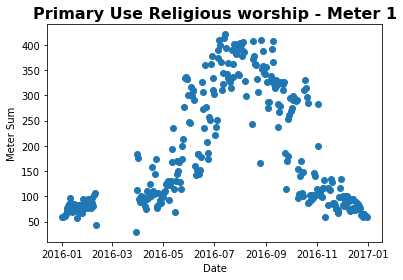

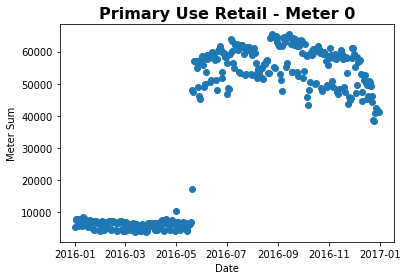

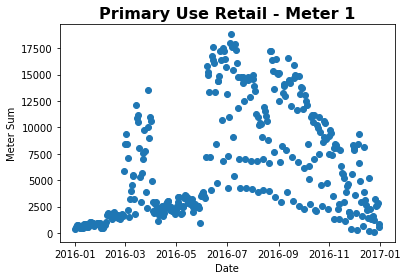

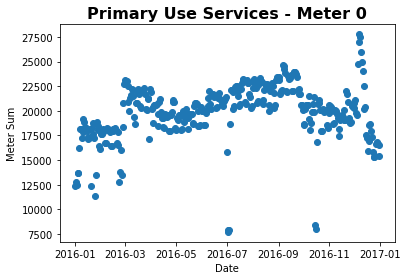

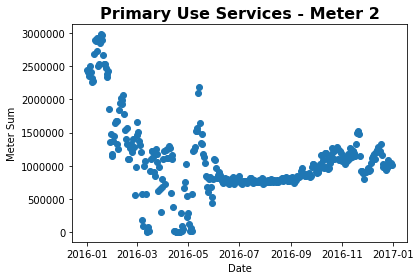

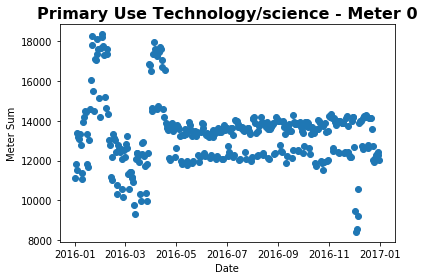

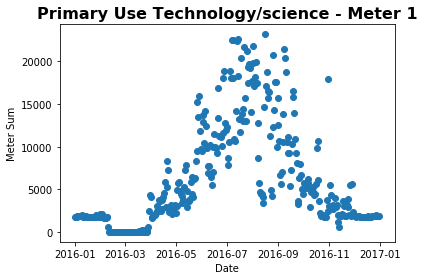

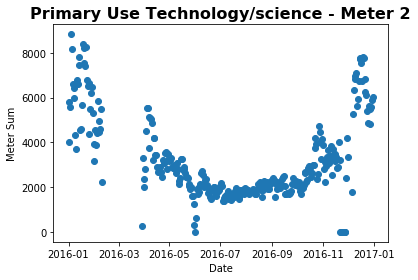

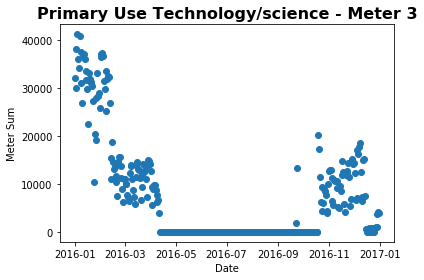

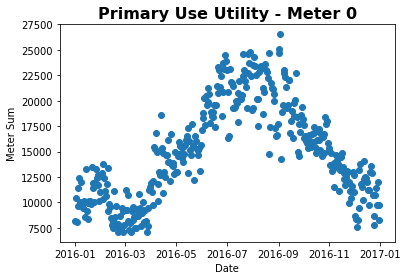

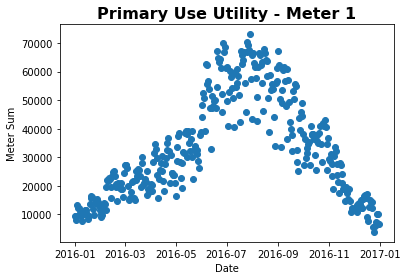

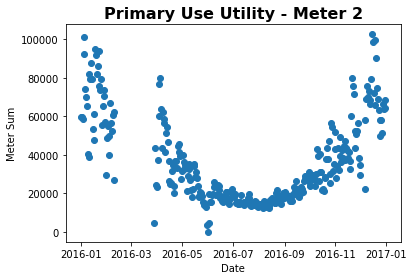

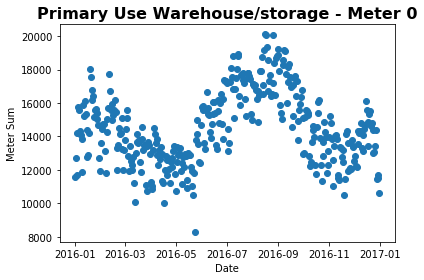

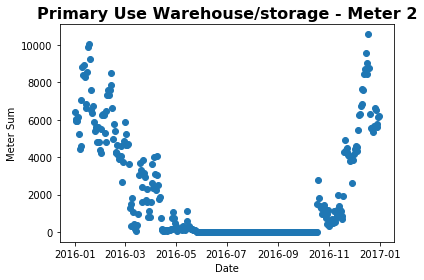

In [12]:
graph_info = graph_df.groupby(['primary_use','meter','data'])['meter_reading'].sum().reset_index()
for primary_use in np.sort(graph_info['primary_use'].unique()):
    for meter in graph_info.loc[graph_info['primary_use']==primary_use,'meter'].unique():
        mask = (graph_info['primary_use']==primary_use) & (graph_info['meter']==meter)
        if scatter:
            plt.plot_date(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
        else:
            sns.lineplot(graph_info.loc[mask,'data'],graph_info.loc[mask,'meter_reading'])
        plt.title("Primary Use {} - Meter {}".format(primary_use,meter),fontsize=16, fontweight='bold')
        plt.xlabel("Date")
        plt.ylabel("Meter Sum")
        plt.show()